# (Un-)constrained sum of least squares (SOLS) in the proxtoolbox
# solved among others with block methods
By Deborah Lepper, April 27, 2023.

## 1. Make proxtoolbox available
If the path of the proxtoolbox is not yet in the PYTHONPATH, you have to add the directory.
If this jupyter-notebook file is located in the same folder level as *ProxPython* you can just execute:

Otherwise adjust the path:

In [1]:
import sys
import os

# add the proxpython directory into the Python's path
sys.path.append(os.getcwd() + "\\ProxPython")

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 2. Proxoperator: projection onto the complex $l1$-ball
The proxoperators in the proxtoolbox were extended s.t. the projection onto a complex $l1$-ball is now available as well as multiple of there projections with different boundarys on different disjoint blocks of $x$.

A *Proj_l1_cmplx_multi* class was implemented to provide the possibility that a cartesian product of complex $l1$-projections can be performed. This is used in the SOLS-experiments. Therefore, a *Proj_l1_cmplx_multi*-object needs the number of blocks (*experiment.Nx*) and the masks for each block (*experiment.masks*), where each block determines one factor of the cartesian product.

In [2]:
from proxtoolbox.proxoperators.Proj_l1_cmplx import Proj_l1_cmplx, Proj_l1_cmplx_multi

In [3]:
# compute projection for an example point

# bound/radius
c = 8

# complex point
x = np.array([2+2*1j,
              8-1*1j,
             -3-4*1j,
             -1+0.8*1j,
              4-5*1j])

# projection
xhat = Proj_l1_cmplx.eval(None,x,c)

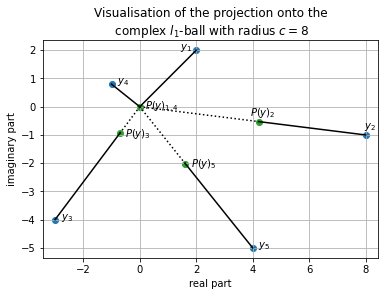

In [4]:
# visualise projection
H = len(x)
plt.figure(f'whole proj mini_{H}D')
plt.title(f'Visualisation of the projection onto the\n complex $l_1$-ball with radius $c={c}$')
for i in range(H):
    plt.plot([np.real(x)[i],np.real(xhat)[i]],[np.imag(x)[i],np.imag(xhat)[i]],'black')
    plt.plot([0,np.real(xhat)[i]],[0,np.imag(xhat)[i]],'black',linestyle='dotted')
plt.scatter(np.real(x),np.imag(x),label=f'g(x)={np.sum(np.abs(x))-c:.1f}')
for i,(xi, yi) in enumerate(zip(np.real(x),np.imag(x))): # label each point
    if i==1:
        plt.text(xi+0.15, yi+0.08, f'$y_{i+1}$', va='bottom', ha='center')
    elif i==0:
        plt.text(xi-0.15, yi+0.08, f'$y_{i+1}$', va='center', ha='right')
    else:
        plt.text(xi+0.2,yi+0.08,f'$y_{i+1}$', va='center', ha='left')
plt.scatter(np.real(xhat),np.imag(xhat),color='tab:green',label=f'g($\hat x$)={np.sum(np.abs(xhat))-c:.1f}')
for i,(xi, yi) in enumerate(zip(np.real(xhat),np.imag(xhat))): # label each point
    if i == 1:
        plt.text(xi+0.15, yi+0.08, f'$P(y)_{i+1}$', va='bottom', ha='center')
    elif i==0:
        plt.text(xi+0.2, yi, '$P(y)_{1,4}$', va='center', ha='left')
    elif i != 3:
        plt.text(xi+0.2,yi,f'$P(y)_{i+1}$', va='center', ha='left')
plt.grid()
plt.axis('equal')
plt.xlabel('real part')
plt.ylabel('imaginary part')
plt.show()

## 3. Proxoperator: algo_in_prox

Another new prox-operator is the **algo_in_prox**. In each evaluation of this prox-operator a complete algorithm will be executed.

So with each call of the function *algo_in_prox.eval*
the algorithm will be instanciated, a new algorithm object will be created and the algorithm will be called to run.

In the experiment class the following attributes must be defined so that the proxoperator *algo_in_prox* can instanciate the algorithm.
- *inner_algorithm*
- *inner_iterate_monitor*
- *inner_accelerator*
- *inner_proxOperators*
- *inner_productProxOperators*
- *inner_dBregman_potential*
- *inner_MAXIT*
- *inner_TOL*
- *inner_silent*

These attributes are needed to provide similar behaviour as the normal algorithm class.

If the attribute *inner_silent* is **True**, the proxoperator algo_in_prox will print results as timing and number of iterations just as the normal algorithm class does. This might result in a lot printed output.
To avoid too much printed output, it is recommended to set *inner_silent* to **False**.

## 4. The Problem: SOLS

The **SumOfLeastSquares_Experiment** includes an optimization problem of the form

\begin{align}
    \min~~  &\sum_{k=1}^{N_z} \lVert A_k x_k + b_k \rVert^2 \\ 
    s.t.~~ &\lVert x_k \rVert_1 = \sum_{j=1}^{N_x} | (x_k)_j | \le c_k, \quad   k=1,\dots,N_z,
\end{align}

where for $k=1,\dots,N_z$ we have 

$$A_k \in\mathbb{C}^{N_y\times N_x}, \quad b_k \in\mathbb{C}^{N_y},\quad
x_k \in\mathbb{C}^{N_x}$$ and $c_k >0$.

Each summand is a disjoint least squares problem, but each constraint connects the summands. Each constraint can be expressed as the complex $l_1$-norm of a block of x. The constraints are completely disjoint, s.t. we can assign them to seperate blocks of $x$ and obtain $N_z$ blocks.

The *SumOfLeastSquares_Experiment* is (as at april 27th, 2023) implemented for the *BCD* and the *GPM* algorithm.
The matrices $A$ and vectors $b$ are randomly created with real and imaginary part in the interval $[-5,4)$.

In [5]:
from proxtoolbox.experiments.BM.SumOfLeastSquares_Experiment import SumOfLeastSquares_Experiment

## 4.1. Algorithm: GPM to solve SOLS
The $k$th iteration of the **GPM**, short term for **gradient projection method**, is given by

\begin{equation*}
    x_{k+1} = P_C(x_k-\alpha_k \nabla f(x_k)),
\end{equation*}

where $\alpha_k>0$ is the *step length* and $P_C(\cdot)$
is the *projection* onto the set $C$.

The GPM in the proxtoolbox is implemented via the so called *eventually constant stepsize* rule. Therefore, it is assumed that the gradient of the objective is Lipschitz-continuous with Lipschitz constant $L$.
The GPM gets an initial steplength $\alpha>0$ as input as same as a reducing factor $0<\beta<1$.
After each iteration the condition

\begin{equation}
    f(x_{k+1}) \le f(x_k) + \nabla f(x_k)^T(x_{k+1}-x_k) + \frac{1}{2\alpha} \lVert x_k-x_{k+1} \rVert^2.
\end{equation}

will be checked. As long as it is not fulfilled, the stepsize $\alpha$ will be reduced by the factor $\beta$.
After finitly many reducings the steplength will be smaller than $\frac 1L$ and the algorithm will converge.

Despite of the steplength $\alpha$ and the reducing factor $\beta$ the GPM expects the objective function $f$ as well as its derivative $df$ and a constraint value $constBound$ as additional input for the prox-operato if $f$ is realr.

The algorithm is defined for real and complex input $x$ if $f$ is real ($df$ might be complex).

## 4.2. Algorithm: BCD to solve SOLS
The **block coordinate descent**, shortly **BCD**, is a iterative algorithm to minimize a continuously differential function $f:\mathbb R^n\to\mathbb R$ over a cartesian product of closed convex and disjoint constraints $C_1\times\dots\times C_m$, where $C_j\subset\mathbb R^{n_j}$ and $\sum_{j=1}^m n_j = n$.

The BCD therefore solves minimization problems like

$$ \min f(x) \quad s.d.~~ x\in C=C_1\times\dots\times C_m. $$

The argument $x$ can be subclassified in the blocks of the constraints so that we can write $x=(x^1,x^2,\dots,x^n)$.
Here, $x^j$ is the so-called *block component*.

The $k$th iterate written with block components end in
$x_k=(x_k^1,\dots,x_k^n)$.

The next iterate $x_{k+1}=(x_{k+1}^1,\dots,x_{k+1}^n)$ will be computed with help of the *cyclic iteration*:

$$ x_{k+1}^j = \underset{\xi\in X_j}{\arg\min}
    f(x_{k+1}^1,\dots,x_{k+1}^{j-1},\xi,x_k^{j+1},\dots,x_k^n),
    \quad j=1,\dots,n. $$
    
This means that the blocks will be chosen one after another and the problem will be solved for this block. The other entries of $x$ will stay constant as parameters.

A cyclic iteration can differ in that way in which order the blocks will be chosen. In the *sequential* order the block components will be chosen in the order from $j=1$ to $j=m$.

In a *randomised* cycle or epoch the blocky will be chosen randomly. One *epoch* is completed if and only if each block was at least once picked. This connect to drawing randomly with replacement.

In the **proxtoolbox**, the BCD will use a prox operator to solve the minimization problem in a cyclic iteration. For that, a *mask* and the *block number* are necessary inputs.

To solve the SOLS-problem with the BCD in the proxtoolbox, each inner minimisation problem of a cyclic iteration will be solved with the GPM-algorithm using the prox operator *algo_in_prox*.


#### Reminder:
In the output of the BCD the iterations correspond to epochs.

## 4.3. Run the BCD and GPM on the SOLS-experiment

Adjusting the input dimensions it is recommended to adjust the tolerances and maximum number of iterations as well as the initial step length for the GPM.

### 4.3.1 unconstrained

In [6]:
# set dimensions for all experiments
Nx = 8
Ny = 12
Nz = 50

load random data of shape (50, 12, 8)
Running GPM on l1-constrained sum of complex least squares...
Took 870 iterations and 2.041602611541748 seconds.

     x    | 	  f(x) 		| 	max(g(x)) 	|      norm(df(x))
 ----------------------------------------------------------------------------
    x0    | 	 9820.0650 	| 	 -inf   	|	 1133.619
    xn    | 	 3634.1747 	| 	 -inf   	|	 0.001
   pinv   | 	 3634.1747 	| 	 -inf   	|	 0.000


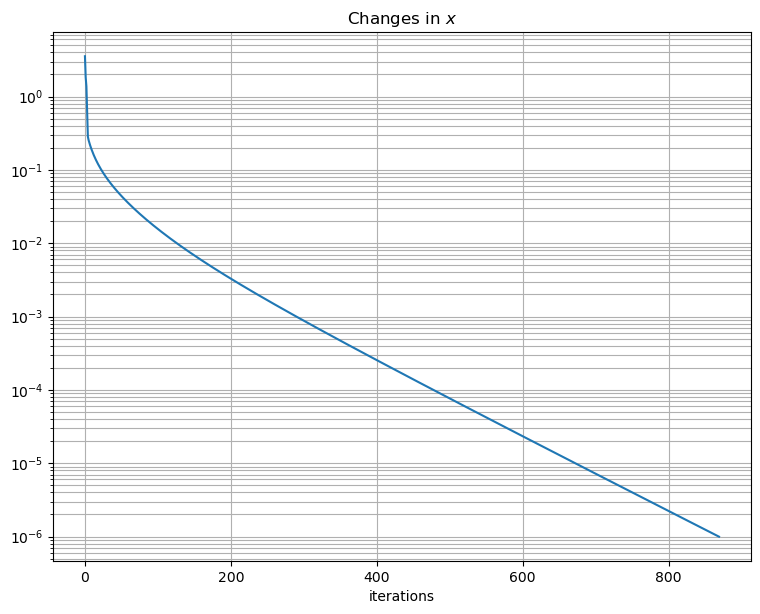

In [7]:
# test the GPM algorithm
BM = SumOfLeastSquares_Experiment(algorithm='GPM',
                     alphaGPM=0.1, betaGPM=0.5,
                     Nx=Nx, Ny=Ny, Nz=Nz,
                     MAXIT=1000, TOL=1e-6, rnd_seed=1234,
                     anim=False)  # if anim=True, more plots in the end will be created,
                                  # but it will take much more computation time
BM.run()
BM.show()

load random data of shape (50, 12, 8)
Running BCD on l1-constrained sum of complex least squares...
Took 117 iterations and 52.23648762702942 seconds.

     x    | 	  f(x) 		| 	max(g(x)) 	|      norm(df(x))
 ----------------------------------------------------------------------------
    x0    | 	 9820.0650 	| 	 -inf   	|	 1133.619
    xn    | 	 3634.1747 	| 	 -inf   	|	 0.000
   pinv   | 	 3634.1747 	| 	 -inf   	|	 0.000


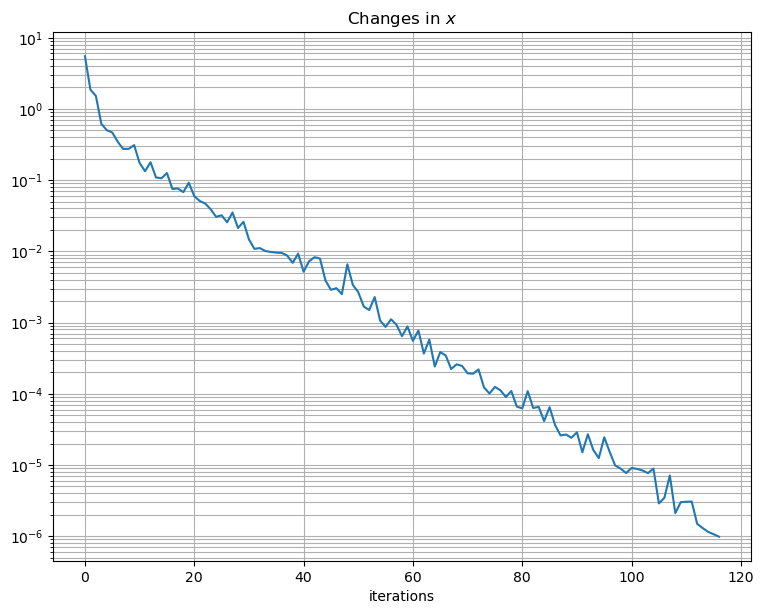

In [8]:
# test the randomized BCD algorithm
BM = SumOfLeastSquares_Experiment(algorithm='BCD',
                     alphaGPM=0.1, betaGPM=0.5,
                     inner_algorithm='GPM',
                     Nx=Nx, Ny=Ny, Nz=Nz,
                     randomizedAlgo=True, MAXIT=150, TOL=1e-6,
                     inner_MAXIT=500, inner_TOL=1e-6,
                     rnd_seed=1234, inner_silent=True,
                     anim=False)  # if anim=True, more plots in the end will be created,
                                  # but it will take much more computation time
BM.run()
BM.show()

load random data of shape (50, 12, 8)
Running BCD on l1-constrained sum of complex least squares...
Took 150 iterations and 30.67025089263916 seconds.

     x    | 	  f(x) 		| 	max(g(x)) 	|      norm(df(x))
 ----------------------------------------------------------------------------
    x0    | 	 9820.0650 	| 	 -inf   	|	 1133.619
    xn    | 	 3634.1747 	| 	 -inf   	|	 0.000
   pinv   | 	 3634.1747 	| 	 -inf   	|	 0.000


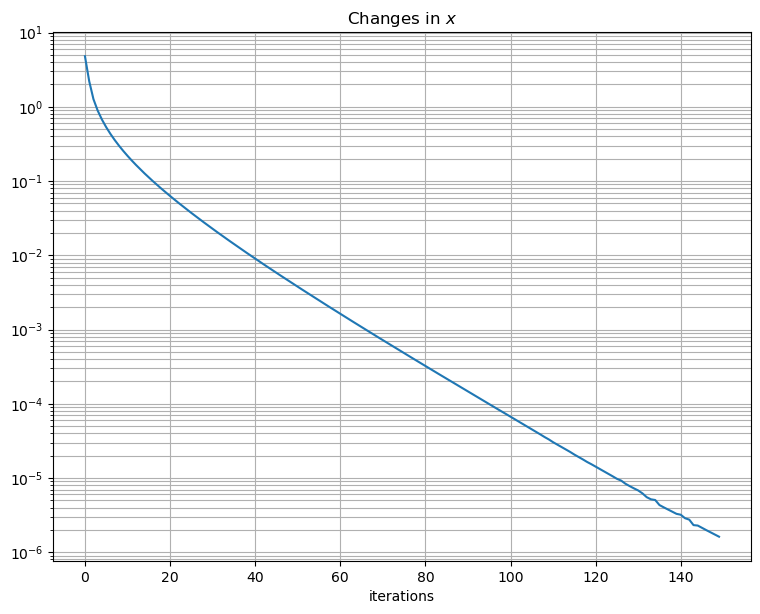

In [9]:
# test the sequentiell BCD algorithm
BM = SumOfLeastSquares_Experiment(algorithm='BCD',
                     alphaGPM=0.1, betaGPM=0.5,
                     inner_algorithm='GPM',
                     Nx=Nx, Ny=Ny, Nz=Nz,
                     randomizedAlgo=False, MAXIT=150, TOL=1e-6,
                     inner_MAXIT=500, inner_TOL=1e-6,
                     rnd_seed=1234, inner_silent=True,
                     anim=False)  # if anim=True, more plots in the end will be created,
                                  # but it will take much more computation time
BM.run()
BM.show()

### 4.3.2 contrained

In [10]:
# set dimensions for all experiments
Nx = 8
Ny = 12
Nz = 50

# set boundaries for constraints (here, each constraint has the same boundary)
c = 20

load random data of shape (50, 12, 8)
Running GPM on l1-constrained sum of complex least squares...
Took 766 iterations and 2.079284191131592 seconds.

     x    | 	  f(x) 		| 	max(g(x)) 	|      norm(df(x))
 ----------------------------------------------------------------------------
    x0    | 	 9820.0650 	| 	 -20.000   	|	 1133.619
    xn    | 	 3669.9385 	| 	 0.000   	|	 45.844
   pinv   | 	 3634.1747 	| 	 5.180   	|	 0.000


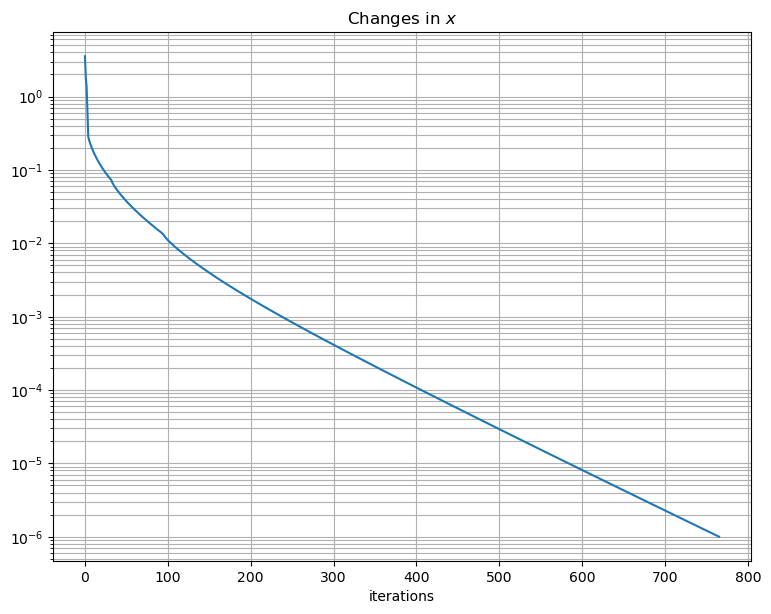

In [11]:
# test the GPM algorithm
BM = SumOfLeastSquares_Experiment(algorithm='GPM',
                     alphaGPM=0.1, betaGPM=0.5,
                     Nx=Nx, Ny=Ny, Nz=Nz, constBound=c,
                     MAXIT=1000, TOL=1e-6, rnd_seed=1234,
                     anim=False)  # if anim=True, more plots in the end will be created,
                                  # but it will take much more computation time
BM.run()
BM.show()

load random data of shape (50, 12, 8)
Running BCD on l1-constrained sum of complex least squares...
Took 106 iterations and 46.54771852493286 seconds.

     x    | 	  f(x) 		| 	max(g(x)) 	|      norm(df(x))
 ----------------------------------------------------------------------------
    x0    | 	 9820.0650 	| 	 -20.000   	|	 1133.619
    xn    | 	 3669.9385 	| 	 0.000   	|	 45.844
   pinv   | 	 3634.1747 	| 	 5.180   	|	 0.000


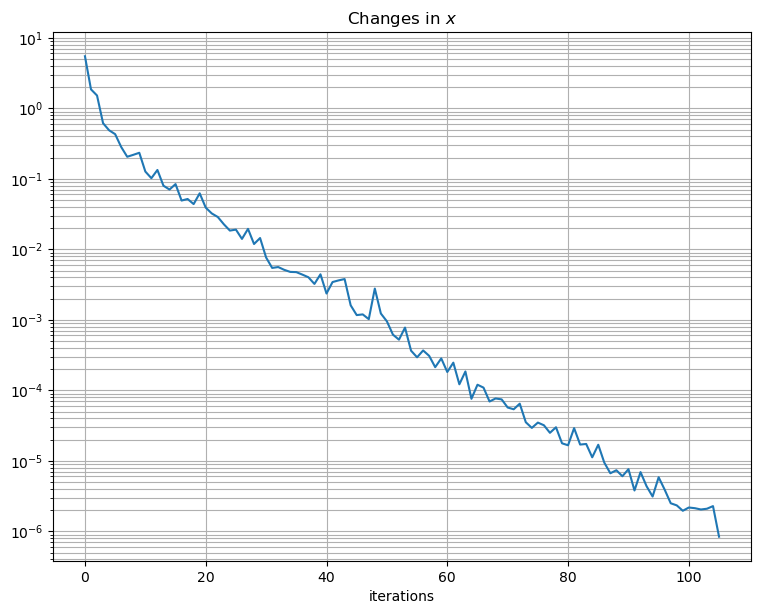

In [12]:
# test the randomized BCD algorithm
BM = SumOfLeastSquares_Experiment(algorithm='BCD',
                     alphaGPM=0.1, betaGPM=0.5,
                     inner_algorithm='GPM',
                     Nx=Nx, Ny=Ny, Nz=Nz, constBound=c,
                     randomizedAlgo=True, MAXIT=150, TOL=1e-6,
                     inner_MAXIT=500, inner_TOL=1e-6,
                     rnd_seed=1234, inner_silent=True,
                     anim=False)  # if anim=True, more plots in the end will be created,
                                  # but it will take much more computation time
BM.run()
BM.show()

load random data of shape (50, 12, 8)
Running BCD on l1-constrained sum of complex least squares...
Took 130 iterations and 26.507766008377075 seconds.

     x    | 	  f(x) 		| 	max(g(x)) 	|      norm(df(x))
 ----------------------------------------------------------------------------
    x0    | 	 9820.0650 	| 	 -20.000   	|	 1133.619
    xn    | 	 3669.9385 	| 	 0.000   	|	 45.844
   pinv   | 	 3634.1747 	| 	 5.180   	|	 0.000


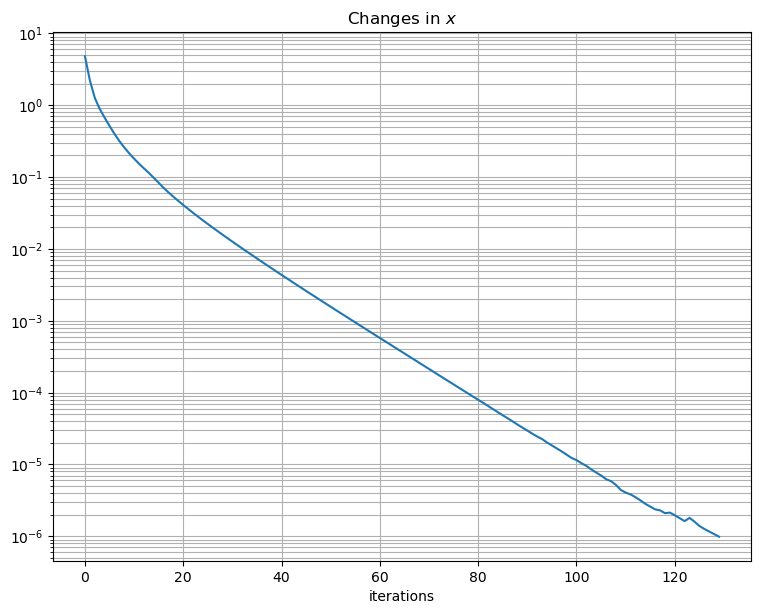

In [13]:
# test the sequentiell BCD algorithm
BM = SumOfLeastSquares_Experiment(algorithm='BCD',
                     alphaGPM=0.1, betaGPM=0.5,
                     inner_algorithm='GPM',
                     Nx=Nx, Ny=Ny, Nz=Nz, constBound=c,
                     randomizedAlgo=False, MAXIT=150, TOL=1e-6,
                     inner_MAXIT=500, inner_TOL=1e-6,
                     rnd_seed=1234, inner_silent=True,
                     anim=False)  # if anim=True, more plots in the end will be created,
                                  # but it will take much more computation time
BM.run()
BM.show()

### 4.3.3 Results

As we would have expected, the randomised BCD is faster in convergence in the number of epochs than the sequentiall BCD.

But compared by time, the sequentiell algorithms is doubled faster. This is the effect that there are a lot more function evaluations and GPM-algorithms running in one randomised epoch than in one sequential cycle.

Just time-comparison gives us that the GPM-algorithm is a lot more faster than the BCD-algorithm. In the unconstraint case as well as in the constraint setting.

Nevertheless, the global solution computed by the BCD is closer to the actual solution, since our objective function is convex and the norm of the gradient at the solution of the GPM is non-zero in the third decimal place whereby the third decimal place of the BCD's solutions are zero. In our example this has no effect to the objective function until at least the fourth decimal place.

Last but not least we can speed up the GPM by adjusting the steplength $\alpha$ as well as the reducing factor $\beta$.

load random data of shape (50, 12, 8)
Running GPM on l1-constrained sum of complex least squares...
Took 550 iterations and 1.3802673816680908 seconds.

     x    | 	  f(x) 		| 	max(g(x)) 	|      norm(df(x))
 ----------------------------------------------------------------------------
    x0    | 	 9820.0650 	| 	 -inf   	|	 1133.619
    xn    | 	 3634.1747 	| 	 -inf   	|	 0.000
   pinv   | 	 3634.1747 	| 	 -inf   	|	 0.000


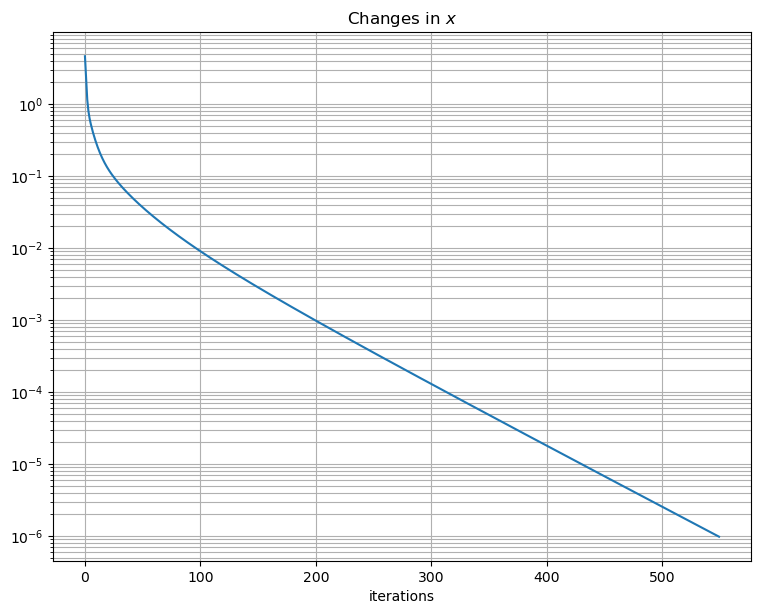

In [14]:
# speed up the GPM algorithm
BM = SumOfLeastSquares_Experiment(algorithm='GPM',
                     alphaGPM=10, betaGPM=0.8,
                     Nx=Nx, Ny=Ny, Nz=Nz,
                     MAXIT=1000, TOL=1e-6, rnd_seed=1234,
                     anim=False)  # if anim=True, more plots in the end will be created,
                                  # but it will take much more computation time
BM.run()
BM.show()